In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import log10, isfinite

Problem 1

In [2]:
f32 = np.float32 #single-precision for numerical work 

def f_cos(x32: np.float32) -> np.float32:
    return np.cos(x32).astype(np.float32)

def f_exp(x32: np.float32) -> np.float32:
    return np.exp(x32).astype(np.float32)

#double precision for more accurate "true" values of the derivatives

def d_cos_true(x64: float) -> float:
    return -np.sin(x64)

def d_exp_true(x64: float) -> float:
    return np.exp(x64)


In [3]:
# Finite-difference algorithms - single precision
def forward_diff(f, x32: np.float32, h32: np.float32) -> np.float32:
    return (f(f32(x32 + h32)) - f(x32)) / h32

def central_diff(f, x32: np.float32, h32: np.float32) -> np.float32:
    return (f(f32(x32 + h32)) - f(f32(x32 - h32))) / (f32(2.0) * h32)

def richardson_from_central(f, x32: np.float32, h32: np.float32) -> np.float32:
    half = f32(0.5) * h32
    Dc_h   = central_diff(f, x32, h32)
    Dc_h2  = central_diff(f, x32, half)
    return Dc_h2 + (Dc_h2 - Dc_h) / f32(3.0)

In [4]:
def run_case(func_name: str, f, dtrue, x_val: float, h_pows=(-8, 0)):
    x32 = f32(x_val)
    
    h = np.power(10.0, np.linspace(h_pows[0], h_pows[1], 81)).astype(np.float64)  # use 64 here for grid definition only
    h32 = h.astype(np.float32)

    # True derivative in float64 for reference
    true = dtrue(float(x_val))

    err_forward = np.empty_like(h, dtype=np.float64)
    err_central = np.empty_like(h, dtype=np.float64)
    err_extrap  = np.empty_like(h, dtype=np.float64)

    for i, hh32 in enumerate(h32):
        # Compute float32 approximations
        df_fwd32 = forward_diff(f, x32, hh32)
        df_ctr32 = central_diff(f, x32, hh32)
        df_ext32 = richardson_from_central(f, x32, hh32)

        # Promote to float64 for error evaluation only
        df_fwd = float(df_fwd32)
        df_ctr = float(df_ctr32)
        df_ext = float(df_ext32)
        
        err_forward[i] = abs((df_fwd - true) / true)
        err_central[i] = abs((df_ctr - true) / true)
        err_extrap[i]  = abs((df_ext - true) / true)

    return dict(
        x=float(x_val),
        func_name=func_name,
        h=h,
        err_forward=err_forward,
        err_central=err_central,
        err_extrap=err_extrap,
        true=true
    )

def significant_digits(rel_err: float) -> float:
    return -log10(rel_err)


In [34]:
# Plotting
def make_plot(rows, title_suffix=""):
    plt.figure(figsize=(11, 9))

    for idx, R in enumerate(rows, start=1):
        plt.subplot(2, 2, idx)
        h = R["h"]
        ef = R["err_forward"]
        ec = R["err_central"]
        ex = R["err_extrap"]

        tiny = 1e-20 #to avoid log(0)
        ef = np.clip(ef, tiny, None)
        ec = np.clip(ec, tiny, None)
        ex = np.clip(ex, tiny, None)

        plt.loglog(h, ef, label="Forward (O(h))", lw=1.6) #log scale 
        plt.loglog(h, ec, label="Central (O(h^2))", lw=1.6)
        plt.loglog(h, ex, label="Extrapolated (O(h^4))", lw=1.6)
        plt.xlabel("step size h")
        plt.ylabel("relative error ε")
        plt.ylim(top=10)
        plt.grid(True, ls=":", alpha=0.6)
        plt.title(f"{R['func_name']}′ at x={R['x']}")

        # Mark minima (best h) for each method
        for arr, name in [(ef, "Fwd"), (ec, "Ctr"), (ex, "Ext")]:
            j = int(np.nanargmin(arr))
            plt.scatter([h[j]], [arr[j]], s=20)
            plt.annotate(name, (h[j], arr[j]),
                         textcoords="offset points", xytext=(6, -6), fontsize=8)

        if idx == 1:
            plt.legend()

    plt.suptitle(f"Finite-difference derivatives in float32 {title_suffix}".strip())
    plt.tight_layout(rect=[0, 0.00, 1, 0.96])


Best observed errors and estimated significant digits:
------------------------------------------------------------------------------------------
Function (x)                 | Method         |        min ε |        h@min | ~sig. digits
------------------------------------------------------------------------------------------
d/dx cos(x) (x=0.1)          | Forward        |    3.319e-04 |    7.943e-05 |         3.48
d/dx cos(x) (x=0.1)          | Central        |    2.340e-06 |    5.012e-03 |         5.63
d/dx cos(x) (x=0.1)          | Extrapolated   |    9.433e-07 |    1.000e-01 |         6.03
d/dx cos(x) (x=10.0)         | Forward        |    3.601e-05 |    1.259e-04 |         4.44
d/dx cos(x) (x=10.0)         | Central        |    9.895e-06 |    1.000e-02 |         5.00
d/dx cos(x) (x=10.0)         | Extrapolated   |    2.943e-07 |    1.259e-01 |         6.53
d/dx exp(x) (x=0.1)          | Forward        |    5.689e-05 |    3.981e-04 |         4.24
d/dx exp(x) (x=0.1)          | Cen

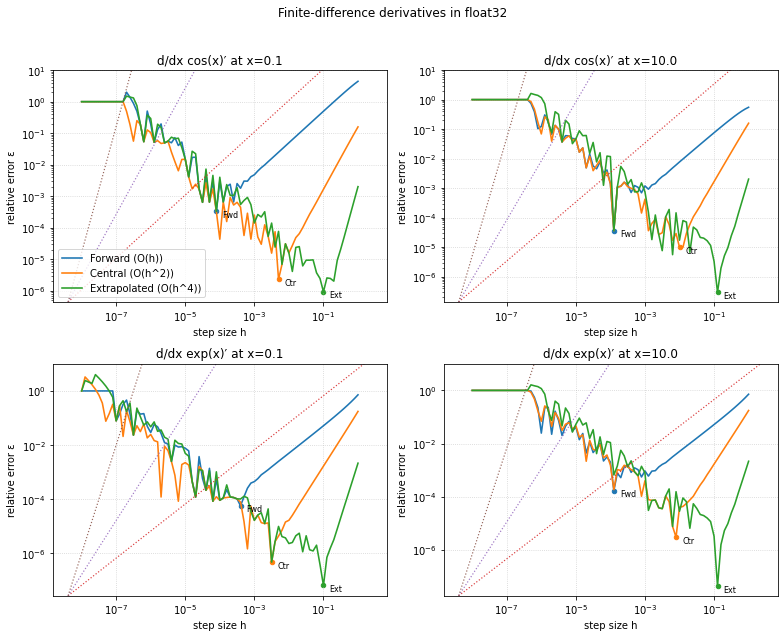

In [36]:
def add_corner_slope_guides(slopes=(1, 2, 4)):
    axes = plt.gcf().axes
    for ai, ax in enumerate(axes):
        xmin, xmax = ax.get_xlim()
        ymin, ymax = ax.get_ylim()
        x0 = xmin * 1.02
        y0 = ymin * 1.02
        x = np.array([x0, xmax], dtype=np.float64)
        for p in slopes:
            y = y0 * (x / x0) ** p
            ax.loglog(x, y, ls=":", lw=1.2, alpha=0.9)            

def main():

    cases = []
    # cos(x)
    cases.append(run_case("d/dx cos(x)", f_cos, d_cos_true, x_val=0.1,  h_pows=(-8, 0)))
    cases.append(run_case("d/dx cos(x)", f_cos, d_cos_true, x_val=10.0, h_pows=(-8, 0)))
    # exp(x)
    cases.append(run_case("d/dx exp(x)", f_exp, d_exp_true, x_val=0.1,  h_pows=(-8, 0)))
    cases.append(run_case("d/dx exp(x)", f_exp, d_exp_true, x_val=10.0, h_pows=(-8, 0)))

    # Plot curves
    make_plot(cases[:4], title_suffix="")

    add_corner_slope_guides(slopes=(1, 2, 4))
    plt.tight_layout(rect=[0, 0.00, 1, 0.96])

    # Print a compact summary table
    print("\nBest observed errors and estimated significant digits:")
    print("-" * 90)
    print(f"{'Function (x)':28s} | {'Method':14s} | {'min ε':>12s} | {'h@min':>12s} | {'~sig. digits':>12s}")
    print("-" * 90)
    for R in cases:
        for name, arr in [("Forward", R["err_forward"]),
                          ("Central", R["err_central"]),
                          ("Extrapolated", R["err_extrap"])]:
            j = int(np.nanargmin(arr))
            emin = float(arr[j])
            hd   = float(R["h"][j])
            sig  = significant_digits(emin)
            label = f"{R['func_name']} (x={R['x']})"
            print(f"{label:28s} | {name:14s} | {emin:12.3e} | {hd:12.3e} | {sig:12.2f}")
    print("-" * 90)

if __name__ == "__main__":
    main()

Problem 2 

In [10]:
def f_expneg(t32: np.float32) -> np.float32:
    return np.exp(-t32).astype(np.float32)

I_true64 = 1.0 - np.exp(-1.0) 


In [11]:
def midpoint_rule(f, a: float, b: float, N: int) -> np.float32:
    a32, b32 = f32(a), f32(b)
    N_int = int(N)
    h32 = f32((b - a) / N_int) 
    i = np.arange(N_int, dtype=np.float32)
    t = a32 + (i + f32(0.5)) * h32
    vals = f(t)
    S = h32 * np.sum(vals, dtype=np.float32)
    return S

def trapezoid_rule(f, a: float, b: float, N: int) -> np.float32:
    a32, b32 = f32(a), f32(b)
    N_int = int(N)
    h32 = f32((b - a) / N_int)
    j = np.arange(N_int + 1, dtype=np.float32)
    t = a32 + j * h32
    vals = f(t)
    sum_internal = np.sum(vals[1:-1], dtype=np.float32) if N_int > 1 else f32(0.0)
    S = h32 * (f32(0.5) * (vals[0] + vals[-1]) + sum_internal) #half weight to endpoints
    return S

def simpson_rule(f, a: float, b: float, N: int) -> np.float32:
    a32, b32 = f32(a), f32(b)
    N_int = int(N)
    h32 = f32((b - a) / N_int)
    j = np.arange(N_int + 1, dtype=np.float32)
    t = a32 + j * h32
    vals = f(t)  # float32
    # odd/even interior indices
    sum_odd  = np.sum(vals[1:-1:2], dtype=np.float32)
    sum_even = np.sum(vals[2:-1:2], dtype=np.float32)
    S = (h32 / f32(3.0)) * (vals[0] + vals[-1] + f32(4.0) * sum_odd + f32(2.0) * sum_even)
    return S

In [12]:
def rel_error(I_approx: np.float32, I_true64: float) -> float:
    return abs((float(I_approx) - I_true64) / I_true64)

In [13]:
def run_sweep(method_name: str, integrator, N_list, force_even=False):
    eps = np.empty(len(N_list), dtype=np.float64)
    N_used = np.empty(len(N_list), dtype=np.int64)

    for k, N in enumerate(N_list):
        N2 = int(N)
        N_used[k] = N2
        I_approx = integrator(f_expneg, 0.0, 1.0, N2) 
        eps[k] = rel_error(I_approx, I_true64)

    return {"method": method_name, "N_used": N_used, "eps": eps}


In [14]:
def fit_loglog(x, y):
    x = np.asarray(x, dtype=np.float64)
    y = np.asarray(y, dtype=np.float64)
    tiny = 1e-300
    X = np.log10(np.clip(x, tiny, None))
    Y = np.log10(np.clip(y, tiny, None))
    a, b = np.polyfit(X, Y, 1)
    return a, b

Finding N*

float32 machine epsilon ≈ 1.192e-07


Minima (empirical N* and ε_min):
------------------------------------------------------
Method                   |         N* |        ε_min
------------------------------------------------------
Midpoint (O(h^2))        |       1024 |    1.447e-08
Trapezoid (O(h^2))       |       2048 |    1.447e-08
Simpson (O(h^4))         |         64 |    1.447e-08
------------------------------------------------------


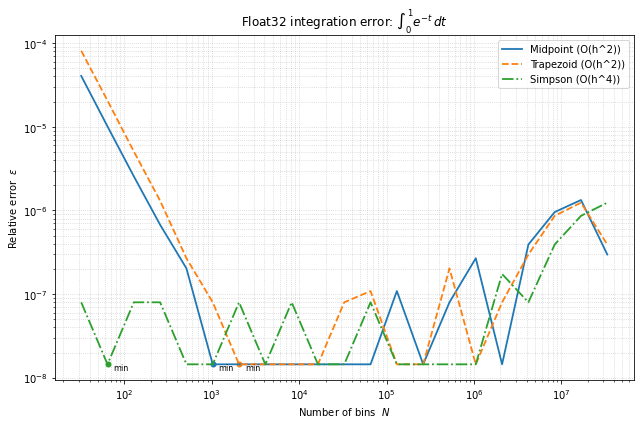

In [19]:
def main():

    k_min, k_max = 5, 25
    N_values = np.unique((2 ** np.arange(k_min, k_max + 1)).astype(int))

    R_mid = run_sweep("Midpoint (O(h^2))",   midpoint_rule,  N_values, force_even=False)
    R_trp = run_sweep("Trapezoid (O(h^2))",  trapezoid_rule, N_values, force_even=False)
    R_sim = run_sweep("Simpson (O(h^4))",    simpson_rule,   N_values, force_even=True)

    results = [R_mid, R_trp, R_sim]

    plt.figure(figsize=(9, 6))
    styles = {"Midpoint (O(h^2))": "-", "Trapezoid (O(h^2))": "--", "Simpson (O(h^4))": "-."}

    for R in results:
        N = R["N_used"].astype(np.float64)
        eps = np.clip(R["eps"], 1e-20, None)  
        plt.loglog(N, eps, styles[R["method"]], lw=1.8, label=R["method"])
        jmin = int(np.nanargmin(eps))
        plt.scatter([N[jmin]], [eps[jmin]], s=25)
        plt.annotate("min", (N[jmin], eps[jmin]), textcoords="offset points", xytext=(6, -6), fontsize=8)

    plt.xlabel("Number of bins  $N$")
    plt.ylabel("Relative error  $\\varepsilon$")
    plt.title("Float32 integration error: $\\int_0^1 e^{-t}\\,dt$")
    plt.grid(True, which="both", ls=":", alpha=0.6)
    plt.legend()
    plt.tight_layout()

    # ------------- Optional quick summary -------------
    print("\nMinima (empirical N* and ε_min):")
    print("-" * 54)
    print(f"{'Method':24s} | {'N*':>10s} | {'ε_min':>12s}")
    print("-" * 54)
    for R in results:
        j = int(np.nanargmin(R["eps"]))
        print(f"{R['method']:24s} | {R['N_used'][j]:10d} | {R['eps'][j]:12.3e}")
    print("-" * 54)

if __name__ == "__main__":
    main()

Problem 3

In [37]:
#load data
fname = "lcdm_z0.matter_pk"
k_raw, Pk_raw = np.loadtxt(fname, comments="#", usecols=(0, 1), unpack=True)


In [38]:
#log scale 
logk = np.log(k_raw)
logP = np.log(Pk_raw)

from scipy.interpolate import PchipInterpolator
pchip = PchipInterpolator(logk, logP, extrapolate=False)
def P_of_k(q):
    out = np.zeros_like(q)
    sel = (q >= k_raw.min()) & (q <= k_raw.max()) #only the range we have data 
    out[sel] = np.exp(pchip(np.log(q[sel])))
    return out

In [39]:
#here, we implement the trapezoidal rule for integration
def trapz_manual(y, x):
    y = np.asarray(y, dtype=np.float64)
    x = np.asarray(x, dtype=np.float64)
    return np.sum(0.5 * (y[:-1] + y[1:]) * (x[1:] - x[:-1]))

def xi_of_r(r, kmin=None, kmax=None, samples_per_period=20):
    r = float(r)
    k0 = k_raw.min()
    k1 = k_raw.max()

    dk = 2*np.pi / (samples_per_period * r)
    npts = int(np.ceil((k1 - k0) / dk)) + 1
    k = np.linspace(k0, k1, npts)

    kr = k * r
    j0 = np.sinc(kr / np.pi)

    integrand = (k**2) * P_of_k(k) * j0
    xi = (1.0 / (2.0 * np.pi**2)) * trapz_manual(integrand, k)
    return xi

def xi_array(r_values, spp=20):
    out = np.empty_like(r_values, dtype=np.float64)
    for i, rr in enumerate(r_values):
        out[i] = xi_of_r(rr, samples_per_period=spp)
    return out


Estimated BAO peak scale: r_peak ≈ 105.72 Mpc/h


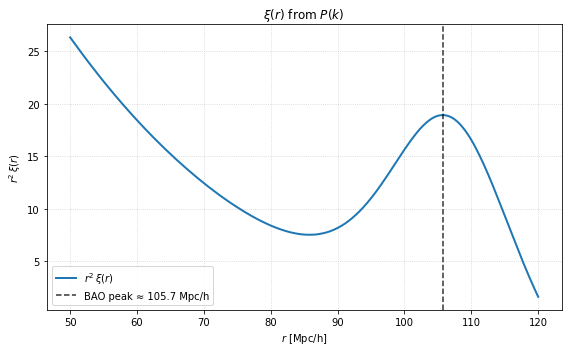

In [40]:
r = np.linspace(50.0, 120.0, 501)
xi = xi_array(r, spp=12)          
r2xi = r**2 * xi #to visually enhance the bump

#after plotting the first time, the initial script identified the peak just at r = 50, so we implemented a mask to find the local peak
search_mask = (r >= 70.0) & (r <= 115.0)
idx = np.where(search_mask)[0]
ipeak = idx[np.argmax(r2xi[idx])]
r_peak = r[ipeak]
print(f"Estimated BAO peak scale: r_peak ≈ {r_peak:.2f} Mpc/h")

plt.figure(figsize=(8,5))
plt.plot(r, r2xi, lw=2.0, label=r"$r^2\,\xi(r)$")
plt.axvline(r_peak, ls="--", alpha=0.8, color="k", label=fr"BAO peak ≈ {r_peak:.1f} Mpc/h")
plt.xlabel(r"$r\ \mathrm{[Mpc/h]}$")
plt.ylabel(r"$r^2\,\xi(r)$")
plt.title(r"$\xi(r)$ from $P(k)$")
plt.grid(True, ls=":", alpha=0.6)
plt.legend()
plt.tight_layout()

We perform a robustness test to check our upper limit. We do not check the lower limit since P(0)=0. 

In [41]:
def xi_array_with_limits(r_values, samples_per_period=20, kmin=None, kmax=None):
    out = np.empty_like(r_values, dtype=np.float64)
    for i, rr in enumerate(r_values):
        out[i] = xi_of_r(rr, kmin=kmin, kmax=kmax, samples_per_period=samples_per_period)
    return out

def robustness_report_kmax(r_grid, kmax_fracs=(0.6, 0.8, 1.0),
                           samples_per_period=20, bao_window=(70.0, 115.0)):
    k0_data, k1_data = float(k_raw.min()), float(k_raw.max())

    kmax_ref = k1_data * float(kmax_fracs[-1])
    xi_ref = xi_array_with_limits(r_grid, samples_per_period, kmin=k0_data, kmax=kmax_ref)
    r2xi_ref = r_grid**2 * xi_ref

    win = (r_grid >= bao_window[0]) & (r_grid <= bao_window[1])
    idx_win = np.where(win)[0]
    ipeak_ref = idx_win[np.argmax(r2xi_ref[idx_win])]
    rpeak_ref = r_grid[ipeak_ref]
    print(f"  baseline r_peak = {rpeak_ref:.2f} Mpc/h")
    for frac in kmax_fracs:
        kmax_cur = k1_data * float(frac)
        xi_cur = xi_array_with_limits(r_grid, samples_per_period, kmin=k0_data, kmax=kmax_cur)
        r2xi_cur = r_grid**2 * xi_cur
        ipeak_cur = idx_win[np.argmax(r2xi_cur[idx_win])]
        rpeak_cur = r_grid[ipeak_cur]

        print(f"  frac={frac:>4.2f}: r_peak={rpeak_cur:6.2f}")


In [42]:
robustness_report_kmax(r, kmax_fracs=(0.6, 0.8, 1.0), samples_per_period=20)

Robustness wrt k_max (relative to baseline at frac = 1.00):
  baseline r_peak = 105.72 Mpc/h
  frac=0.60: r_peak=105.72
  frac=0.80: r_peak=105.72
  frac=1.00: r_peak=105.72
